# Bayesian Inference in Visual-SB2 Systems
### Information and Decision Systems Group<br>University of Chile

Example of Bayesian inference in visual-SB2 systems.

In [1]:
import os
import sys
import logging
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm.notebook import tqdm
from cmdstanpy import CmdStanModel
sys.path.append( '../src' )
from utils import update_namespace, read_in3, getOrbit, getRV

## 1. Observations

In [2]:
system = 'HIP111170'

### 1.1. Data Parsing

In [3]:
df_as, df_v1, df_v2, df_priors = read_in3('./data/{}.in3'.format(system))
print('Astrometric observations:')
display(df_as)
print('V1 observations:')
display(df_v1)
print('V2 observations:')
display(df_v2)

Astrometric observations:


,epoch,X,Y,X_err,Y_err
0,1985.5150,-0.008534,-0.095620,0.009,0.009
1,1988.6660,-0.026764,-0.085928,0.009,0.009
2,1989.9350,-0.031234,0.037755,0.009,0.009
3,2000.8730,-0.022885,-0.086007,0.002,0.002
4,2001.7520,0.011826,0.030808,0.006,0.006
5,2002.7990,-0.008105,-0.092646,0.004,0.004
6,2014.7630,-0.018832,-0.082888,0.003,0.003
7,2014.8560,-0.017115,-0.081216,0.003,0.003
8,2015.7380,0.002617,0.049931,0.003,0.003
9,2016.3900,-0.025165,-0.076992,0.003,0.003


V1 observations:


,epoch,RV,err
0,1964.713460,-3.40,1.11
1,1965.426138,-19.60,1.11
2,1965.461457,-23.20,1.11
3,1965.483360,-23.30,1.11
4,1965.969887,-10.60,1.11
...,...,...,...
134,1986.808229,-4.31,1.11
135,1986.896932,-4.00,1.11
136,1986.928374,-2.82,1.11
137,1987.944273,-24.76,1.11


V2 observations:


,epoch,RV,err
0,1981.694929,-21.48,2.9
1,1981.820766,-22.90,2.9
2,1982.434364,-13.01,2.9
3,1982.893969,13.60,2.9
4,1983.752832,-21.78,2.9
5,1983.781191,-23.20,2.9
6,1984.577542,18.54,2.9
7,1984.648618,8.09,2.9
8,1984.735829,0.12,2.9
9,1984.741247,-3.76,2.9


### 1.2. Data Visualization

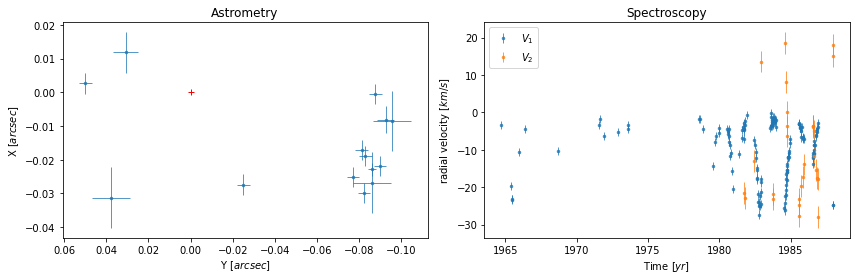

In [4]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.errorbar(df_as.Y, df_as.X, xerr=df_as.Y_err, yerr=df_as.X_err, fmt='.', elinewidth=1, ms=5, alpha=0.75)
plt.plot([0],[0],'+',color='r')
plt.xlabel(r'Y $[arcsec]$')
plt.ylabel(r'X $[arcsec]$')
plt.gca().invert_xaxis()
plt.title('Astrometry')
plt.subplot(1,2,2)
plt.errorbar(df_v1.epoch, df_v1.RV, yerr=df_v1.err, label=r'$V_1$', fmt='.', elinewidth=1, ms=5, alpha=0.75)
plt.errorbar(df_v2.epoch, df_v2.RV, yerr=df_v2.err, label=r'$V_2$', fmt='.', elinewidth=1, ms=5, alpha=0.75)
plt.ylabel(r'radial velocity [$km/s$]')
plt.xlabel('Time [$yr$]')
plt.title('Spectroscopy')
plt.legend()
plt.tight_layout()
plt.show()

## 2. Bayesian Inference

### 2.1. Statistical Model

In [5]:
# Model paths
stan_file = '../src/visual_sb2.stan'
user_header = '../src/kepler_eq.hpp'

In [6]:
# Model compilation
update_namespace(user_header, os.path.basename(stan_file).replace('.stan', ''))
model = CmdStanModel(stan_file=stan_file, user_header=user_header)
print(model.code())

INFO:cmdstanpy:compiling stan file /home/miguel/Desktop/BinaryStars/src/visual_sb2.stan to exe file /home/miguel/Desktop/BinaryStars/src/visual_sb2
INFO:cmdstanpy:compiled model executable: /home/miguel/Desktop/BinaryStars/src/visual_sb2


functions {
    real kepler_eq(real M, real e);
    vector[] orbit(int N, vector t, real T, real P, real e, real a, real w, real Omega, real i) {
        // Variables declaration
        real M; real A; real B; real F; real G;
        vector[N] E; vector[N] x; vector[N] y; vector[N] pos[2];
        // Iterate over epochs
        for (j in 1:N) {
            // Mean anomaly
            M = 2 * pi() * (t[j] - T) / P;
            // Eccentric anomaly
            E[j] = kepler_eq(M, e);
        }
        // Auxiliary normalized coordinates
        x = cos(E) - e;
        y = sin(E) * sqrt(1 - e^2);
        // Thiele-Innes constants
        A = a * (cos(w) * cos(Omega) - sin(w) * sin(Omega) * cos(i));
        B = a * (cos(w) * sin(Omega) + sin(w) * cos(Omega) * cos(i));
        F = a * (-sin(w) * cos(Omega) - cos(w) * sin(Omega) * cos(i));
        G = a * (-sin(w) * sin(Omega) + cos(w) * cos(Omega) * cos(i));
        // Apparent orbit
        pos[1] = A * x + F * y;
        pos[2] = B * x +

In [7]:
# Orbital data dictionary
# The keys and values must match the variables of the `data` block shown in model.code()
data = dict(N_as=len(df_as), 
            N_v1=len(df_v1),
            N_v2=len(df_v2),
            t_as=df_as.epoch.tolist(),
            t_v1=df_v1.epoch.tolist(),
            t_v2=df_v2.epoch.tolist(),
            x_obs=df_as.X.tolist(),
            y_obs=df_as.Y.tolist(),
            x_err=df_as.X_err.tolist(),
            y_err=df_as.Y_err.tolist(),
            v1_obs=df_v1.RV.tolist(),
            v1_err=df_v1.err.tolist(),
            v2_obs=df_v2.RV.tolist(),
            v2_err=df_v2.err.tolist())

### 2.2. Optimization Stage

In [8]:
# Initial points dictionary
# The keys and values must match the variables of the `parameters` block shown in model.code() 
V_mean = np.array(df_v1.RV.tolist() + df_v2.RV.tolist()).mean()
def init_func():
    return dict(T0=np.random.uniform(0, 1), 
                log_P=np.log(632.606 / 365.25), # Providing a previous estimate of P is highly recommended 
                                                # (e.g., from sb9 or orb6 catalogues).
                e=np.random.uniform(0, 1), 
                a=np.random.uniform(0, 1),
                w=np.random.uniform(0, 2*np.pi),
                Omega=np.random.uniform(0, 2*np.pi),
                i=np.random.uniform(0, np.pi),
                V0=np.random.uniform(V_mean-10, V_mean+10),
                plx=np.random.uniform(0, 10),
                q=np.random.uniform(0, 1))

In [9]:
# Maximum likelihood estimation
best_mle = dict(lp__=-np.inf)
logging.getLogger().setLevel(logging.FATAL)
for _ in tqdm(range(1000)):
    mle = model.optimize(data=data, inits=init_func(), require_converged=False).optimized_params_dict
    if mle['lp__'] > best_mle['lp__']:
        best_mle = mle
        print("Current maximum log-probability: {0:.4f}".format(best_mle['lp__']))
logging.getLogger().setLevel(logging.INFO)
best_mle

  0%|          | 0/1000 [00:00<?, ?it/s]

Current maximum log-probability: -7422.6600
Current maximum log-probability: -4631.8600
Current maximum log-probability: -4031.5000
Current maximum log-probability: -4027.1100
Current maximum log-probability: -3766.0900
Current maximum log-probability: -3424.4600
Current maximum log-probability: -115.4960
Current maximum log-probability: -115.4950


OrderedDict([('lp__', -115.495),
             ('T0', 0.43667),
             ('log_P', 0.548919),
             ('e', 0.366327),
             ('a', 0.0673949),
             ('w', 3.00058),
             ('Omega', 4.57203),
             ('i', 1.16204),
             ('V0', -9.56479),
             ('plx', 0.0358988),
             ('q', 0.534558),
             ('P', 1.73138),
             ('w_deg', 171.921),
             ('Omega_deg', 261.958),
             ('i_deg', 66.5798),
             ('T', 1965.47),
             ('m1', 1.43838),
             ('m2', 0.768898),
             ('plx_mas', 35.8988),
             ('f_plx', 9.70359)])

### 2.3. Inference Stage

In [10]:
# MCMC Sampling
fit = model.sample(data=data, iter_warmup=2500, iter_sampling=2500, inits=best_mle, sig_figs=8)
fit.summary()

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-130.000,0.034000,2.20000,-130.000,-130.000,-130.000,4300.0,49.0,1.0
T0,0.440,0.000074,0.00570,0.430,0.440,0.450,5900.0,67.0,1.0
log_P,0.550,0.000003,0.00031,0.550,0.550,0.550,9500.0,110.0,1.0
e,0.370,0.000120,0.01000,0.350,0.370,0.380,7500.0,86.0,1.0
a,0.067,0.000011,0.00093,0.066,0.067,0.069,6600.0,76.0,1.0
w,3.000,0.000400,0.03200,2.900,3.000,3.100,6300.0,72.0,1.0
Omega,4.600,0.000230,0.01800,4.500,4.600,4.600,5800.0,67.0,1.0
i,1.200,0.000480,0.03800,1.100,1.200,1.200,6400.0,73.0,1.0
V0,-9.600,0.000940,0.09400,-9.700,-9.600,-9.400,9900.0,110.0,1.0


## 3. Results

### 3.1. Variables Selection

In [11]:
df = fit.draws_pd()[['P', 'T', 'e', 'a', 'w_deg', 'Omega_deg', 'i_deg', 'V0', 'plx_mas', 'm1', 'm2', 'q', 'lp__']]
df.columns = [r'$P$ $[yr]$', r'$T$ $[yr]$', r'$e$', r'$a$ $[″]$', r'$\omega$ $[°]$',r'$\Omega$ $[°]$',
              r'$i$ $[°]$', r'$V_{0}$ $[km/s]$', r'$\pi$ $[mas]$', r'$m_1$ $[M_\odot]$', r'$m_2$ $[M_\odot]$', 
              r'$q$', 'lp__']
df

,$P$ $[yr]$,$T$ $[yr]$,$e$,$a$ $[″]$,$\omega$ $[°]$,$\Omega$ $[°]$,$i$ $[°]$,$V_{0}$ $[km/s]$,$\pi$ $[mas]$,$m_1$ $[M_\odot]$,$m_2$ $[M_\odot]$,$q$,lp__
0,1.730464,1965.4824,0.373637,0.066290,171.55781,260.82696,67.712900,-9.603086,36.640639,1.262567,0.715016,0.566320,-129.70278
1,1.732024,1965.4677,0.384245,0.065183,173.12749,261.07589,68.268879,-9.601817,36.236505,1.242268,0.697965,0.561848,-132.08472
2,1.730106,1965.4873,0.369059,0.066779,172.34606,261.14949,67.007404,-9.669176,36.387202,1.328050,0.736997,0.554947,-129.83725
3,1.731621,1965.4701,0.366708,0.068002,172.87140,260.56656,66.266185,-9.658468,36.827834,1.360577,0.739026,0.543171,-129.40880
4,1.731247,1965.4807,0.372105,0.065855,173.11087,262.44938,66.909020,-9.520818,36.091379,1.309935,0.717029,0.547377,-129.99183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.731372,1965.4633,0.372884,0.069483,169.90998,261.73342,68.295026,-9.529977,37.406277,1.403830,0.734256,0.523038,-130.97976
9996,1.731248,1965.4596,0.347681,0.066962,169.71324,262.15045,69.702926,-9.838591,35.497358,1.483175,0.756460,0.510027,-136.13450
9997,1.731137,1965.4623,0.368922,0.069961,169.06922,260.83359,69.480746,-9.471110,38.407389,1.305002,0.711819,0.545454,-133.96382
9998,1.731504,1965.4564,0.349006,0.068043,169.72295,262.77347,70.428704,-9.446960,37.392234,1.303723,0.706095,0.541599,-132.44322


### 3.2. Point Estimates

In [12]:
# Samples
samples = df.drop(columns=['lp__']).to_numpy()
# MAP sample
map_sample = samples[df[['lp__']].to_numpy().argmax()]
# Uncertainty quantification
#lb = np.quantile(samples, 0.25, axis=0) # Quartile 1
#ub = np.quantile(samples, 0.75, axis=0) # Quartile 3
lb = az.hdi(samples, 0.95)[:,0] # 95% HPDI lower bound
ub = az.hdi(samples, 0.95)[:,1] # 95% HPDI upper bound

/tmp/ipykernel_12135/4117480441.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  lb = az.hdi(samples, 0.95)[:,0] # 95% HPDI lower bound
/tmp/ipykernel_12135/4117480441.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ub = az.hdi(samples, 0.95)[:,1] # 95% HPDI upper bound


In [13]:
# Estimates summary table
summary_table = [[df.columns[i], 
                  r'${:.3f}_{{{:.3f}}}^{{{:.3f}}}$'.format(map_sample[i], lb[i], ub[i])] for i in range(len(map_sample))]
df_summary = pd.DataFrame(summary_table, columns=['Parameter', 'Estimate'])
df_summary

,Parameter,Estimate
0,$P$ $[yr]$,$1.732_{1.730}^{1.732}$
1,$T$ $[yr]$,$1965.464_{1965.450}^{1965.487}$
2,$e$,$0.365_{0.347}^{0.386}$
3,$a$ $[″]$,$0.067_{0.066}^{0.069}$
4,$\omega$ $[°]$,$171.355_{168.358}^{175.462}$
5,$\Omega$ $[°]$,$262.150_{260.091}^{264.027}$
6,$i$ $[°]$,$66.849_{62.375}^{70.827}$
7,$V_{0}$ $[km/s]$,$-9.553_{-9.744}^{-9.380}$
8,$\pi$ $[mas]$,$35.467_{33.564}^{38.563}$
9,$m_1$ $[M_\odot]$,$1.504_{1.147}^{1.741}$


## 4. Visualization

### 4.1. Marginal Posterior Distributions

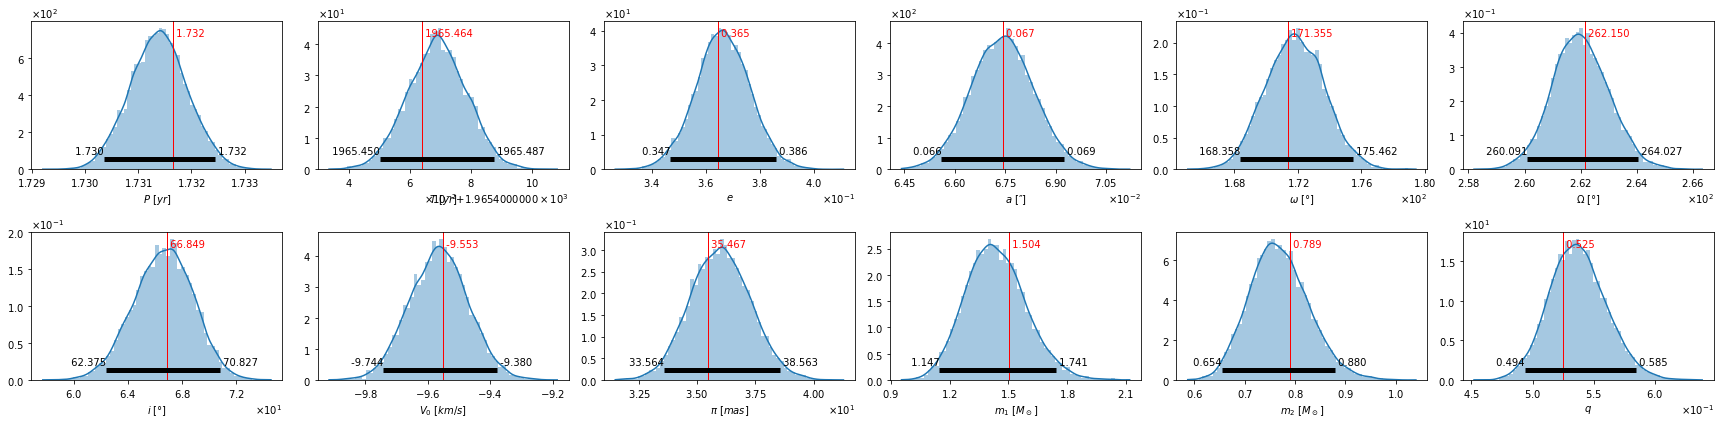

In [14]:
params_names = df.drop(columns=['lp__']).columns.tolist()
plt.figure(figsize=(24,6))
for i in range(samples.shape[1]):
    plt.subplot(2,6,i+1)
    sns.histplot(samples[:,i], stat='density', kde=True, color='tab:blue', alpha=0.4, **{"edgecolor": None})
    min_ylim, max_ylim = plt.ylim()
    plt.axvline(map_sample[i], color='red', linewidth=1)
    plt.text(map_sample[i], max_ylim * 0.9, ' {:.3f}'.format(map_sample[i]), color='red')
    plt.hlines(y=max_ylim * 0.07, xmin=lb[i], xmax=ub[i], linewidth=5, color='black')
    plt.text(lb[i], max_ylim * 0.1, ' {:.3f}'.format(lb[i]), color='black', horizontalalignment='right') 
    plt.text(ub[i], max_ylim * 0.1, ' {:.3f}'.format(ub[i]), color='black') 
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0), useMathText=True)
    plt.xlabel(params_names[i])
    plt.ylabel(None) 
plt.tight_layout()
plt.show()

### 4.2. Pair Posterior Distributions

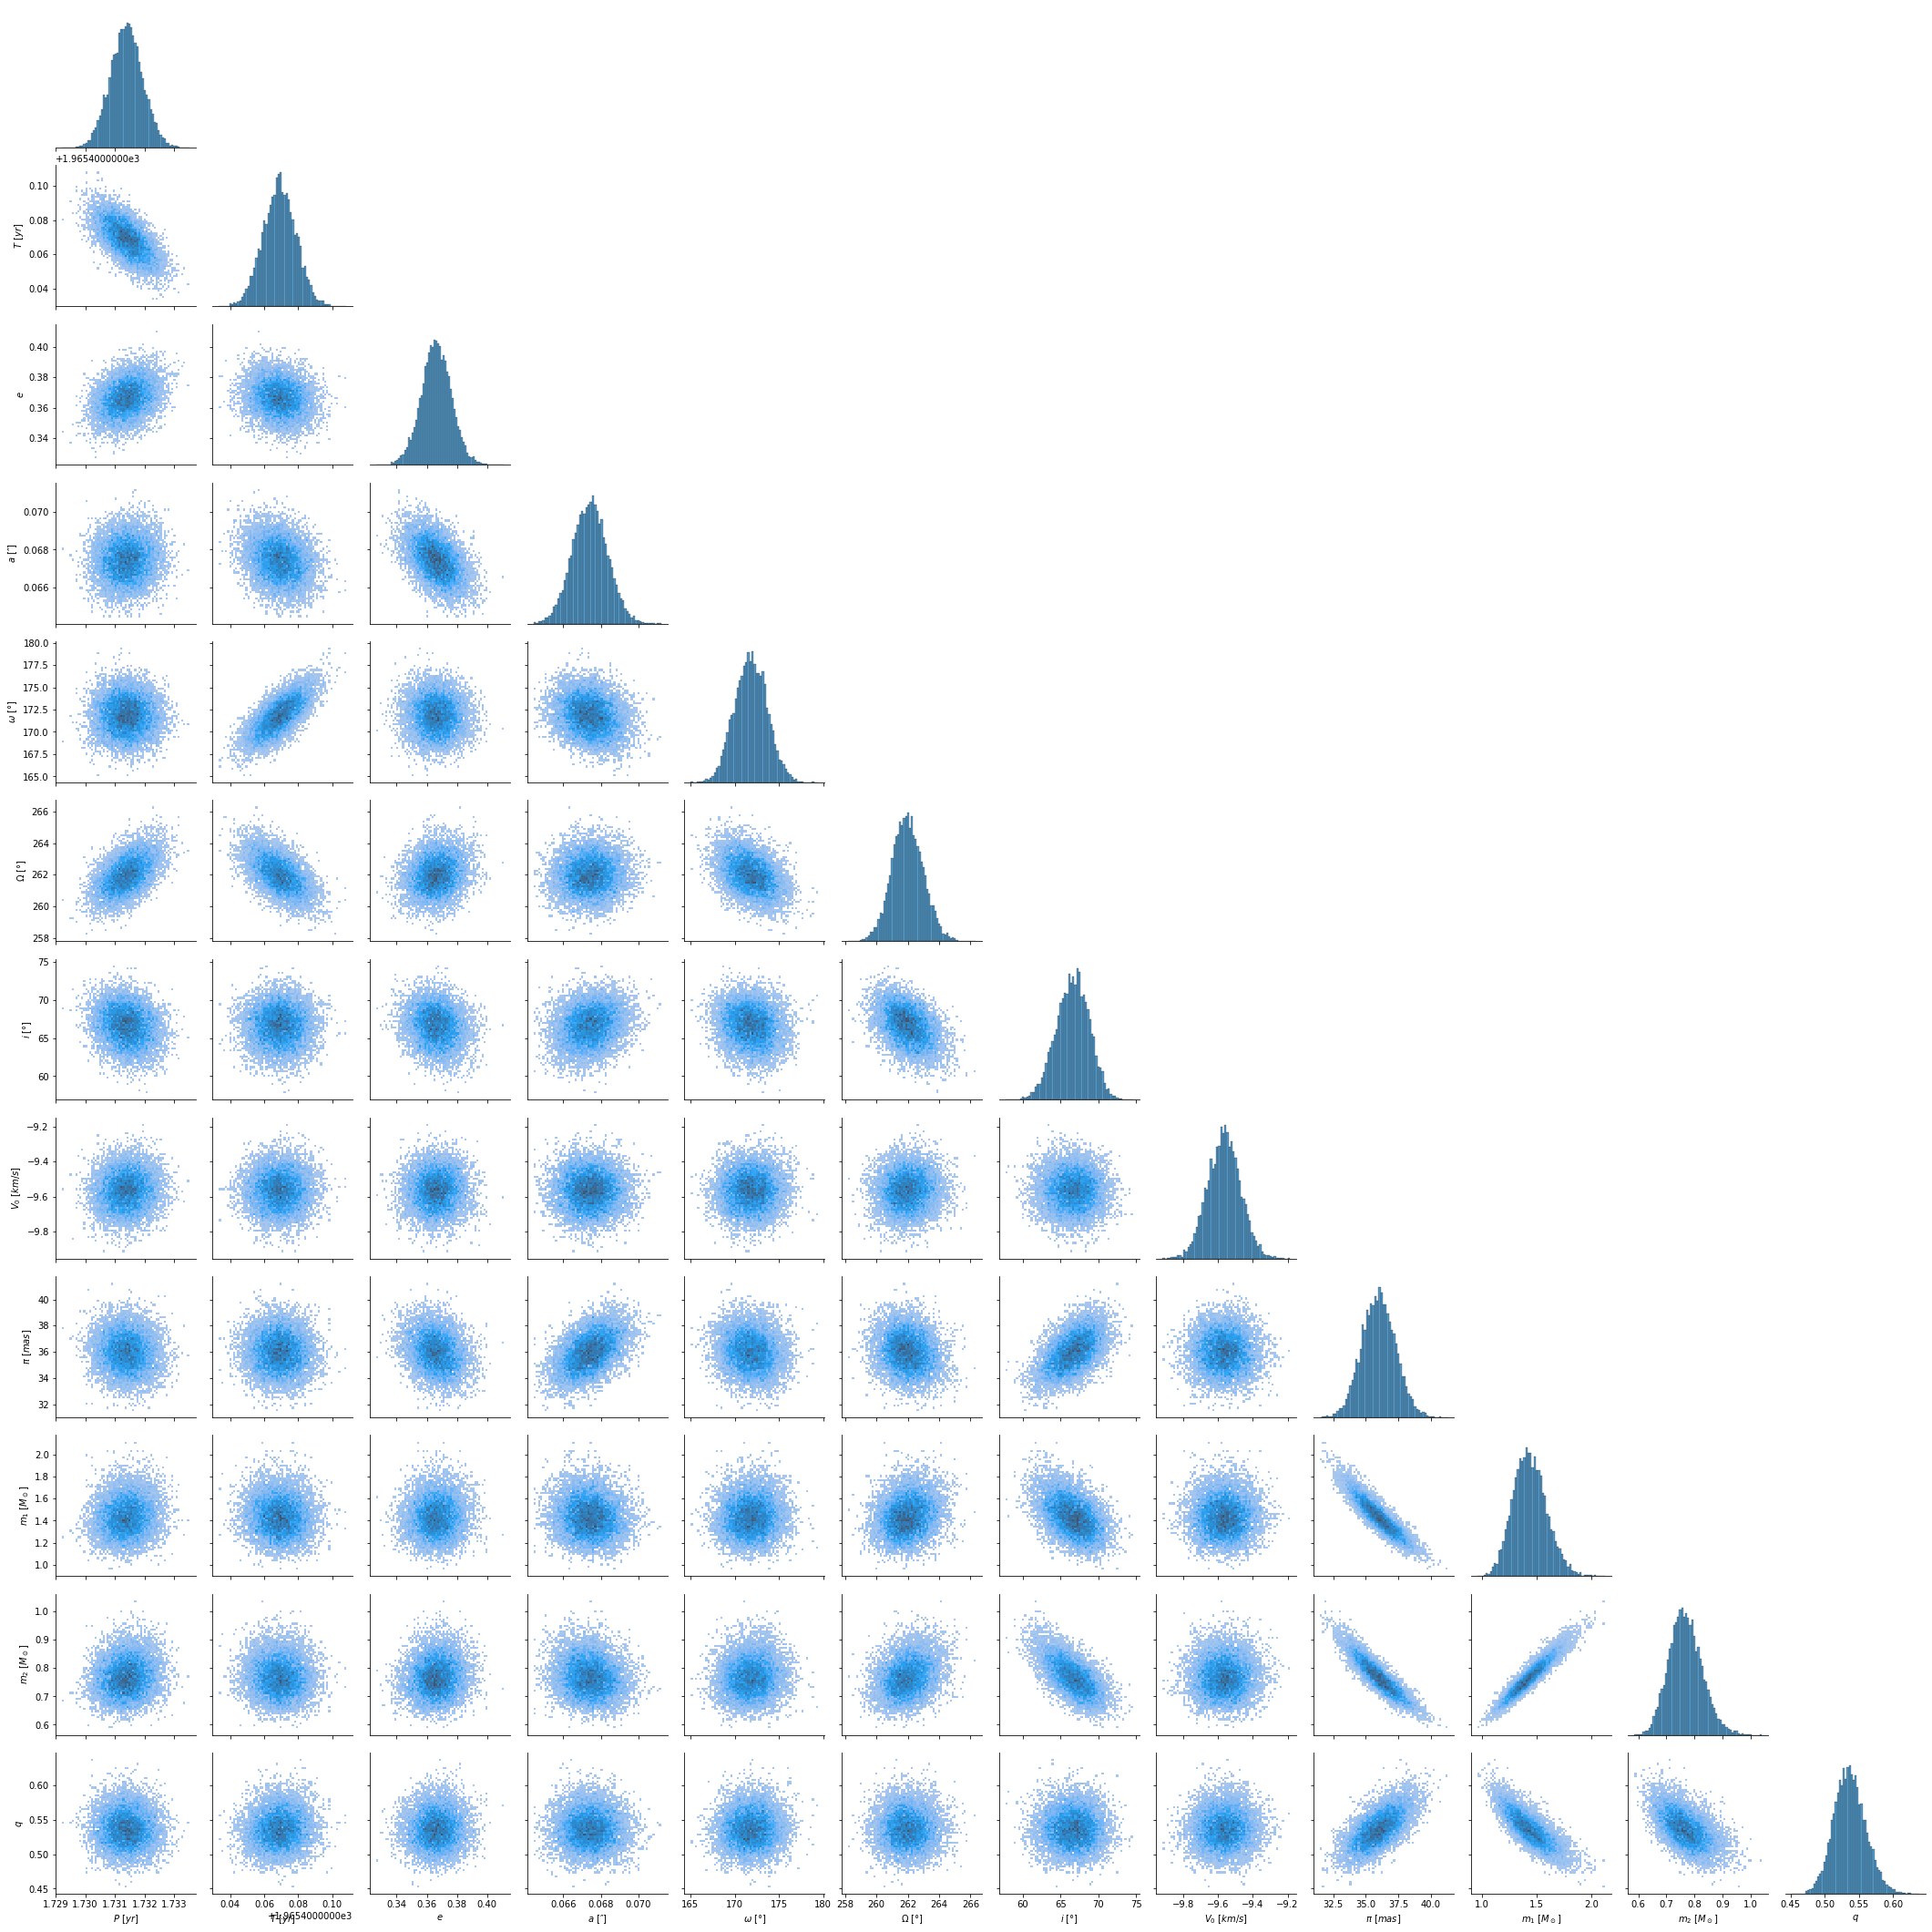

In [15]:
sns.pairplot(df.drop(columns='lp__'), kind='hist', corner=True)
plt.show()

### 4.3. Orbit & Radial Velocity Curve

In [16]:
# Aesthetics utils
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Greys_r')
cmap_p = plt.get_cmap('Blues_r')
cmap_s = plt.get_cmap('Reds_r')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

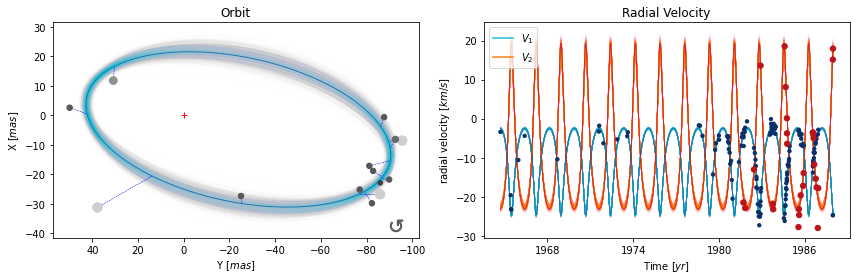

In [17]:
### Orbit & RV
plt.figure(figsize=(12,4))
rnd_idx = np.random.choice(samples.shape[0], 1000, replace=False)

### Orbit plot
plt.subplot(1, 2, 1)
# Orbit samples
for j in tqdm(range(1000)):
    P, T, e, a, w, Omega, i, V0, plx, m1, m2, q = samples[rnd_idx[j]]
    t = np.linspace(0, P, 1000)
    X, Y = getOrbit(t, T, P, e, a, np.deg2rad(w), np.deg2rad(Omega), np.deg2rad(i))
    plt.plot(Y * 1000, X * 1000, color='tab:cyan', alpha=0.005)
# MAP orbit
P, T, e, a, w, Omega, i, V0, plx, m1, m2, q = map_sample
t = np.linspace(0, P, 1000)
X, Y = getOrbit(t, T, P, e, a, np.deg2rad(w), np.deg2rad(Omega), np.deg2rad(i))
# Data projection on the MAP orbit
Xorb, Yorb = getOrbit(df_as.epoch.to_numpy(), T, P, e, a, np.deg2rad(w), np.deg2rad(Omega), np.deg2rad(i))
plt.plot(Y * 1000, X * 1000, color='tab:blue', linewidth=1, zorder=j)
for k in range(len(df_as)):
    plt.plot([df_as.Y[k]  * 1000, Yorb[k] * 1000], [df_as.X[k] * 1000, Xorb[k] * 1000], '--', color='blue', linewidth=0.5)
# Dataset
plt.scatter(df_as.Y * 1000, df_as.X * 1000, s=df_as.X_err * 10000, c=df_as.X_err, cmap=truncate_colormap(cmap, 0.2, 0.7), zorder=2000)
plt.plot([0], [0], '+', color='r')
legend = plt.gca().get_legend()
plt.xlabel(r'Y $[mas]$')
plt.ylabel(r'X $[mas]$')
plt.title('Orbit')
plt.gca().invert_xaxis()
# Orientation symbol: marker={r'$\circlearrowleft$', r'$\circlearrowright$'}
plt.plot([0.9 * plt.xlim()[1]],[0.9 * plt.ylim()[0]], marker=r'$\circlearrowleft$',ms=15, mew=0.5, color='black', alpha=0.6)

### RV plot
plt.subplot(1, 2, 2)
t = np.linspace(min(df_v1.epoch.min(), df_v2.epoch.min()), max(df_v1.epoch.max(), df_v2.epoch.max()), 3000)
# RV samples
for j in tqdm(range(1000)):
    P, T, e, a, w, Omega, i, V0, plx, m1, m2, q = samples[rnd_idx[j]]
    V1, V2 = getRV(t, T, P, e, a, np.deg2rad(w), np.deg2rad(i), V0, plx * 0.001, q)
    plt.plot(t, V1, color='tab:cyan', alpha=0.005)
    plt.plot(t, V2, color='tab:orange', alpha=0.005)
plt.plot([], [], color='tab:cyan', label=r'$V_1$')
plt.plot([], [], color='tab:orange', label=r'$V_2$')
# MAP RV
P, T, e, a, w, Omega, i, V0, plx, m1, m2, q = map_sample
V1, V2 = getRV(t, T, P, e, a, np.deg2rad(w), np.deg2rad(i), V0, plx * 0.001, q)
plt.plot(t, V1, linewidth=1, color='tab:blue')
plt.plot(t, V2, linewidth=1, color='tab:red')  
plt.scatter(df_v1.epoch, df_v1.RV, s=df_v1.err * 10, c=df_v1.err, cmap=truncate_colormap(cmap_p, 0, 0.3), zorder=3)
plt.scatter(df_v2.epoch, df_v2.RV, s=df_v2.err * 10, c=df_v2.err, cmap=truncate_colormap(cmap_s, 0.2, 0.5), zorder=4)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('radial velocity [$km/s$]')
plt.xlabel('Time $[yr]$')
plt.legend(loc='upper left')
plt.title('Radial Velocity')
plt.tight_layout()
plt.show()